## 1. Set up Mario and Controls

In [1]:
!pip install gym_super_mario_bros==7.3.0 nes_py

In [2]:
# import the game
import gym_super_mario_bros
# import the joypad wrapper
from nes_py.wrappers import JoypadSpace
# import controls (simplified)
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [3]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [4]:
# Set up the game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [5]:
# Check how many actions can the env can choose
env.action_space

Discrete(7)

In [6]:
# Output of the simulator (i.e. a frame)
env.observation_space.shape

(240, 256, 3)

In [ ]:
# # Play the game
# done = True

# # Loop through (100000) steps
# for steps in range(10000):
#     if done:
#         # start the game
#         env.reset()
#     # take random actions from the SIMPLE_MOVEMENT in each step
#     state, reward, done, info = env.step(env.action_space.sample())
#     env.render()
# # close the game
# env.close()

In [ ]:
env.close()

In [ ]:
# state is a frame which will be passed into the AI model for training
state = env.reset()
state.shape

In [ ]:
# info attribute of env
env.step(1)[3]

In [ ]:
env.close()

## 2. Preprocessing
Gray-scaling and Frame-stacking

In [7]:
# install PyTorch
# !pip3 install torch torchvision torchaudio
!pip3 install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

# install baseline3
!pip install stable-baselines3[extra]

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [8]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import FrameStack, GrayScaleObservation

# Impport Vectorization Wrappers 
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [9]:
# Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale
env = GrayScaleObservation(env, keep_dim = True)
# Wrap inside the dummy environment
env = DummyVecEnv([lambda: env])
# Stack frames
env = VecFrameStack(env, 4, channels_order = 'last')

In [10]:
state = env.reset()

In [11]:
state.shape

(1, 240, 256, 4)

In [12]:
step = env.action_space.sample()
print(SIMPLE_MOVEMENT[step])
state, reward, done, info = env.step([step])

['left']


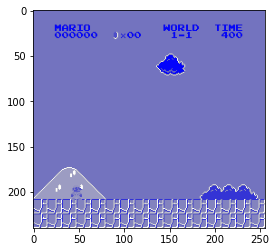

In [13]:
plt.imshow(state[0])

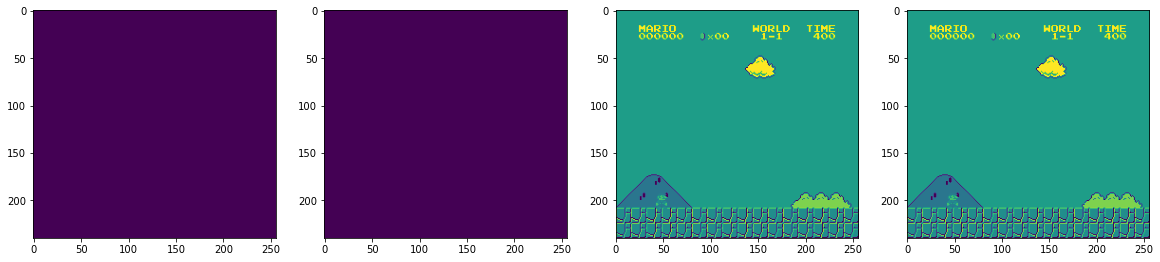

In [14]:
plt.figure(figsize = (20, 16))
for idx in range(state.shape[3]):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(state[0][:, :, idx])
plt.show()

## 3. RL model and Training

In [15]:
import os
# import PPO for algorithm
from stable_baselines3 import PPO
# import Base callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [16]:
# # Optional: save models regularly for backtracking purposes
# class TrainAndLoggingCallback(BaseCallback):

#     def __init__(self, check_freq, save_path, verbose=1):
#         super(TrainAndLoggingCallback, self).__init__(verbose)
#         self.check_freq = check_freq
#         self.save_path = save_path

#     def _init_callback(self):
#         if self.save_path is not None:
#             os.makedirs(self.save_path, exist_ok=True)

#     def _on_step(self):
#         if self.n_calls % self.check_freq == 0:
#             model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
#             self.model.save(model_path)

#         return True

In [17]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [18]:
# # Setup model saving callback
# callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [19]:
model = PPO('CnnPolicy', env, verbose = 1, tensorboard_log = LOG_DIR, 
            learning_rate = 0.0001, n_steps = 512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [20]:
model.learn(total_timesteps = 1000000
           # , callback = callback
           )

Logging to ./logs/PPO_1


C:\Users\zemia\anaconda3\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 42  |
|    iterations      | 1   |
|    time_elapsed    | 11  |
|    total_timesteps | 512 |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 57         |
|    iterations           | 2          |
|    time_elapsed         | 17         |
|    total_timesteps      | 1024       |
| train/                  |            |
|    approx_kl            | 0.02182791 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.93      |
|    explained_variance   | -0.00248   |
|    learning_rate        | 0.0001     |
|    loss                 | 18         |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00616   |
|    value_loss           | 120        |
----------------------------------------
-----------------------------------------
| time/          

KeyboardInterrupt: 

## 4. Testing / Applying best model to env

In [21]:
model = PPO.load('train/best_model_100000')

FileNotFoundError: [Errno 2] No such file or directory: 'train\\best_model_100000.zip'

In [ ]:
state = env.reset()

while True:
    action _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()